## Personalized Movie & TV Show Recommender

In [95]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Importing scikit-learn modules for preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # For encoding categorical variables and scaling
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Importing scikit-learn models for regression/classification
from sklearn.metrics import silhouette_score

# Optionally, import visualization libraries
import matplotlib.pyplot as plt  # For plotting data
import seaborn as sns  # For statistical data visualization
import matplotlib as mpl

# For warnings (optional)
import warnings
warnings.filterwarnings("ignore")


### Data Cleaning and Analysis

In [96]:
df=pd.read_csv('Disney_data.csv')
df.head()

,url,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,NaN,Blondie,movie,"Comedy, Family",1938.0,tt0029927,6.9,885.0,"US, ZA"
1,NaN,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8735.0,JP
2,https://www.amazon.com/dp/B00FJV0DIE,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,112484.0,"AT, DE"
3,NaN,Judgment Night,movie,"Action, Crime, Drama",1993.0,tt0107286,6.6,19268.0,US
4,https://www.amazon.com/dp/B002QVZ71I,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2313221.0,"AT, CU, DE, IN, JP, SN"


##### Since we don't need the url for analysis we are dropping that column

In [97]:
df=df.drop("url",axis=1)
df.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Blondie,movie,"Comedy, Family",1938.0,tt0029927,6.9,885.0,"US, ZA"
1,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8735.0,JP
2,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,112484.0,"AT, DE"
3,Judgment Night,movie,"Action, Crime, Drama",1993.0,tt0107286,6.6,19268.0,US
4,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2313221.0,"AT, CU, DE, IN, JP, SN"


##### Since we can see that year column and imdbNumVotes are in float, we convert that column into integer

In [98]:
df['releaseYear']=pd.to_numeric(df['releaseYear'], errors='coerce').fillna(0).astype(int)
df['imdbNumVotes']=pd.to_numeric(df['imdbNumVotes'], errors='coerce').fillna(0).astype(int)
df.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Blondie,movie,"Comedy, Family",1938,tt0029927,6.9,885,"US, ZA"
1,Ariel,movie,"Comedy, Crime, Romance",1988,tt0094675,7.4,8735,JP
2,Four Rooms,movie,Comedy,1995,tt0113101,6.7,112484,"AT, DE"
3,Judgment Night,movie,"Action, Crime, Drama",1993,tt0107286,6.6,19268,US
4,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2313221,"AT, CU, DE, IN, JP, SN"


##### Now we find the missing values in the dataframe

In [99]:
df.isna().sum()

title                 1500
type                     0
genres                1130
releaseYear              0
imdbId                2896
imdbAverageRating     3608
imdbNumVotes             0
availableCountries       0
dtype: int64

Since there is some missing values in titles, genres, Id, Rating and Votes, replacing that with 0 or NA won't make any sense. Hence dropping all the rows which contains null value would be the efficient step

##### We drop the rows which contains the missing values

In [100]:
df1=df.dropna().reset_index(drop=True)

In [101]:
df1.isna().sum()

title                 0
type                  0
genres                0
releaseYear           0
imdbId                0
imdbAverageRating     0
imdbNumVotes          0
availableCountries    0
dtype: int64

In [102]:
df1.shape

(48756, 8)

##### Now we find the unique values in type column

In [103]:
df1['type'].value_counts()

type
movie    42146
tv        6610
Name: count, dtype: int64

So there are two types of data
1. Movies
2. Tv shows

And this data comprised of 42,146 movie data and 6610 tv shows data

Now we are going to encode the categorical variable which will be then fed to the ML model

In [104]:
df1['genres'] = df1['genres'].apply(lambda x: x.split(', '))
df1['availableCountries'] = df1['availableCountries'].apply(lambda x: x.split(', '))
df1.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Blondie,movie,"[Comedy, Family]",1938,tt0029927,6.9,885,"[US, ZA]"
1,Ariel,movie,"[Comedy, Crime, Romance]",1988,tt0094675,7.4,8735,[JP]
2,Four Rooms,movie,[Comedy],1995,tt0113101,6.7,112484,"[AT, DE]"
3,Judgment Night,movie,"[Action, Crime, Drama]",1993,tt0107286,6.6,19268,[US]
4,Forrest Gump,movie,"[Drama, Romance]",1994,tt0109830,8.8,2313221,"[AT, CU, DE, IN, JP, SN]"


In [105]:
types_val=[]
for i in df1['type']:
    types_val.append([i])
    

In [106]:
# Encoding types
mlb = MultiLabelBinarizer()
encoded_types = mlb.fit_transform(types_val)
encoded_types_df = pd.DataFrame(encoded_types, columns=mlb.classes_)

# Encoding genres
encoded_genres = mlb.fit_transform(df1['genres'])
encoded_genres_df = pd.DataFrame(encoded_genres, columns=mlb.classes_)

#Encoding Countries
encoded_countries = mlb.fit_transform(df1['availableCountries'])
encoded_countries_df = pd.DataFrame(encoded_countries, columns=mlb.classes_)

# Concatenate back to the original DataFrame
final_df = pd.concat([df1,encoded_types_df, encoded_genres_df,encoded_countries_df], axis=1)
final_df.head()


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,movie,tv,...,TZ,UG,US,UY,VA,VE,YE,ZA,ZM,ZW
0,Blondie,movie,"[Comedy, Family]",1938,tt0029927,6.9,885,"[US, ZA]",1,0,...,0,0,1,0,0,0,0,1,0,0
1,Ariel,movie,"[Comedy, Crime, Romance]",1988,tt0094675,7.4,8735,[JP],1,0,...,0,0,0,0,0,0,0,0,0,0
2,Four Rooms,movie,[Comedy],1995,tt0113101,6.7,112484,"[AT, DE]",1,0,...,0,0,0,0,0,0,0,0,0,0
3,Judgment Night,movie,"[Action, Crime, Drama]",1993,tt0107286,6.6,19268,[US],1,0,...,0,0,1,0,0,0,0,0,0,0
4,Forrest Gump,movie,"[Drama, Romance]",1994,tt0109830,8.8,2313221,"[AT, CU, DE, IN, JP, SN]",1,0,...,0,0,0,0,0,0,0,0,0,0


##### Correlation Between Rating and Number of Votes

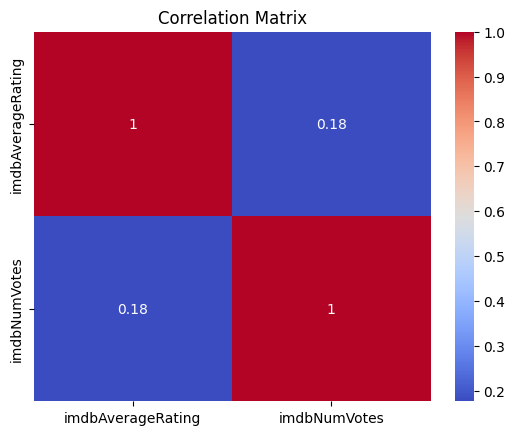

In [107]:
correlation_matrix = final_df[['imdbAverageRating','imdbNumVotes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

From the above correlation map it is clear that the number of voting having less impact on imdb rating since the correlation coefficient is only 0.18

### Trend Analysis

Now we are going to analyse the genre trend over the years

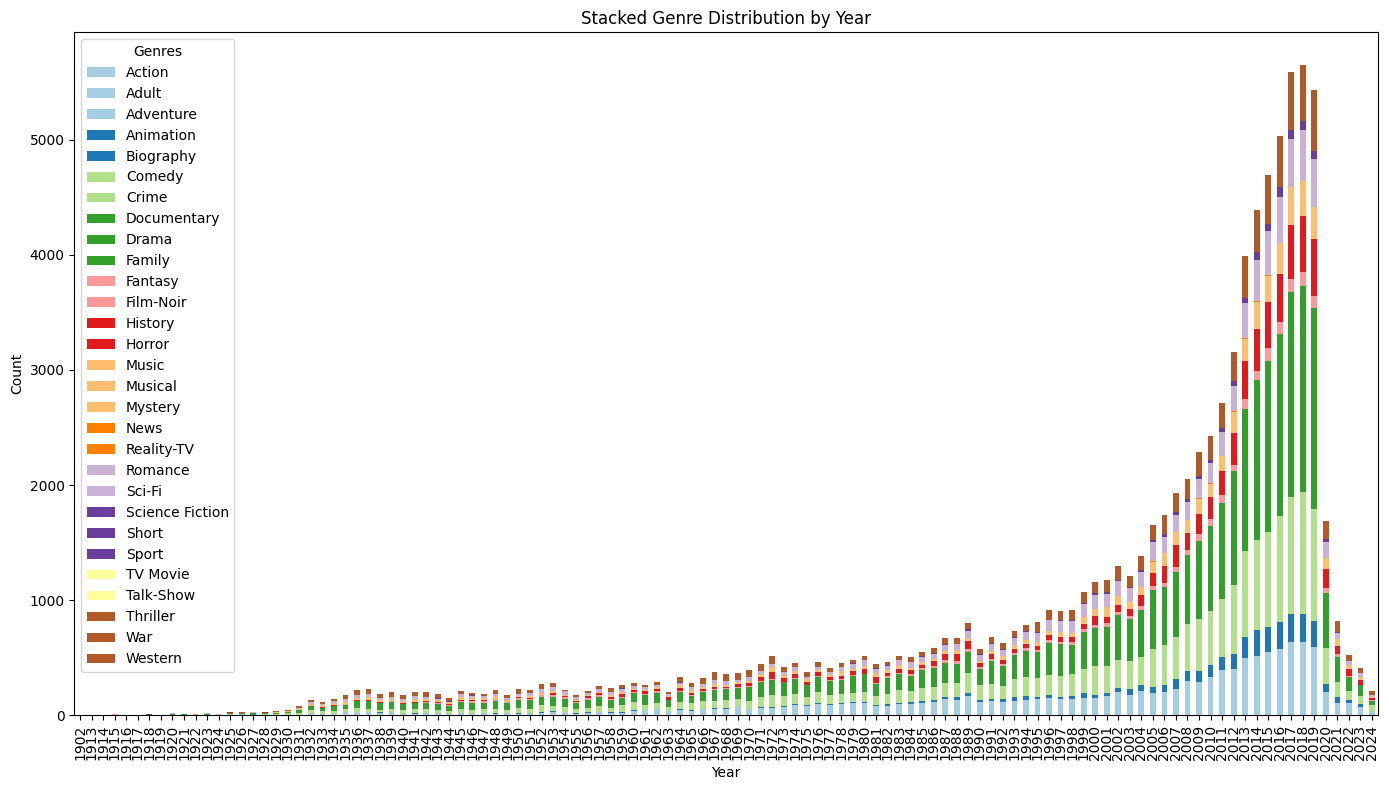

In [108]:
# Step 1: Filter the dataframe by movie and Explode the genres column to have one genre per row
df_movie = df1[df1['type']=='movie']
df_movie_exploded = df_movie.explode('genres')

# Step 2: Group by releaseYear and genres, then count occurrences
genre_movie_trend = df_movie_exploded.groupby(['releaseYear', 'genres']).size().unstack(fill_value=0)


# Step 3: Plot stacked bar plot for genre distribution by year
genre_movie_trend.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Paired')
plt.title("Stacked Genre Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Genres", loc='upper left')
plt.tight_layout()
plt.show()


Here we can able to witness that the trend of watching movies increased over years and decreased drastically by 2020.
Covid outbreak might be major reason that people going to watching movies decreased as well as making movies at those period also drastically decreased.

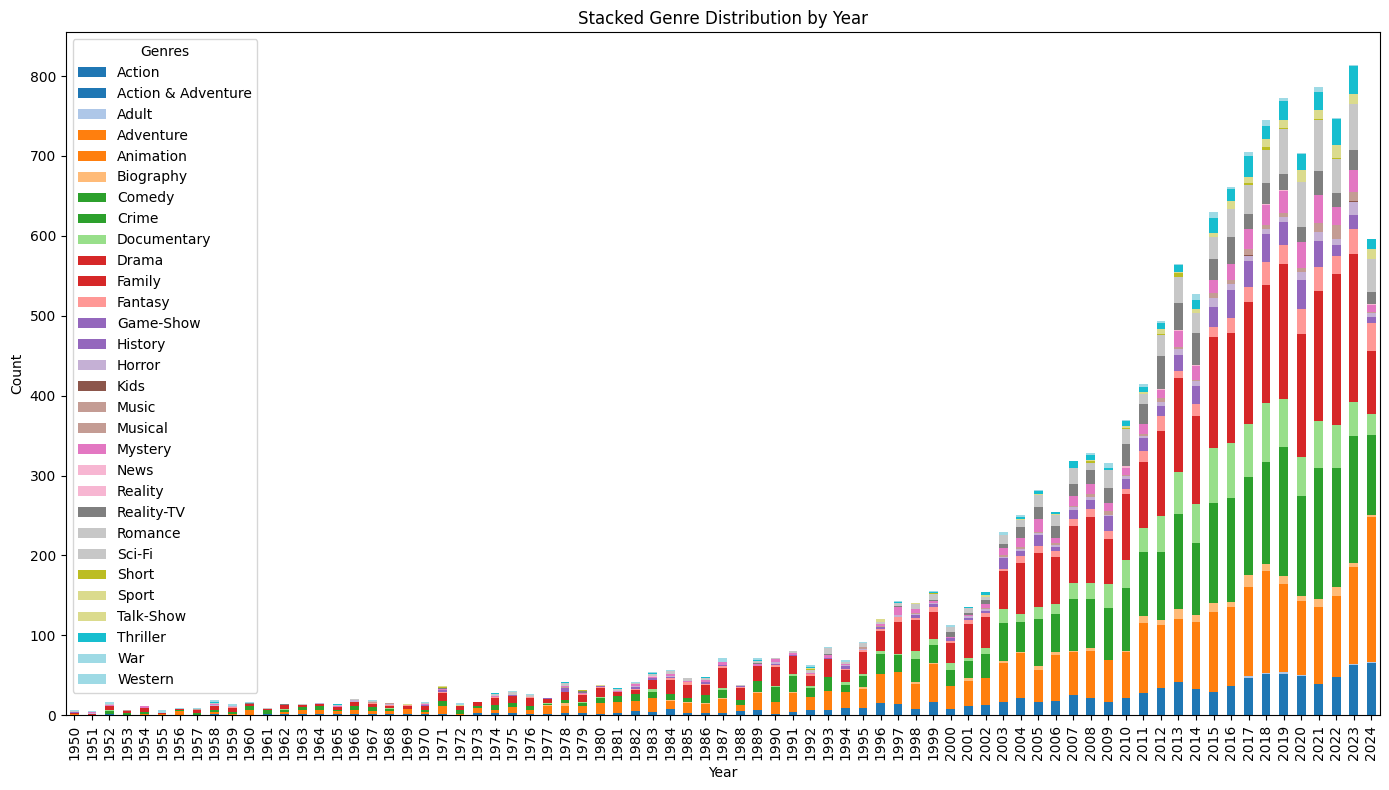

In [109]:
# Step 1: Filter the dataframe by tv show type and Explode the genres column to have one genre per row
df_tv=df1[df1['type']=='tv']
df_tv_exploded = df_tv.explode('genres')

# Step 2: Group by releaseYear and genres, then count occurrences
genre_tv_trend = df_tv_exploded.groupby(['releaseYear', 'genres']).size().unstack(fill_value=0)

# Step 3: Calculate the total count per genre and sort genres by total count in descending order
genre_tv_total_counts = genre_tv_trend.sum().sort_values(ascending=False)
tv_top_3_genres = genre_tv_total_counts.head(3).index
tv_bottom_3_genres = genre_tv_total_counts.tail(3).index

# Step 4: Plot stacked bar plot for genre distribution by year
genre_tv_trend.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title("Stacked Genre Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Genres", loc='upper left')
plt.tight_layout()
plt.show()

In tv shows we can able to witness the increasing trend over years and covid outbreak doesn't seems to have any effect in this as these are available in OTT

Now we can find the Distribution of Movie Genres

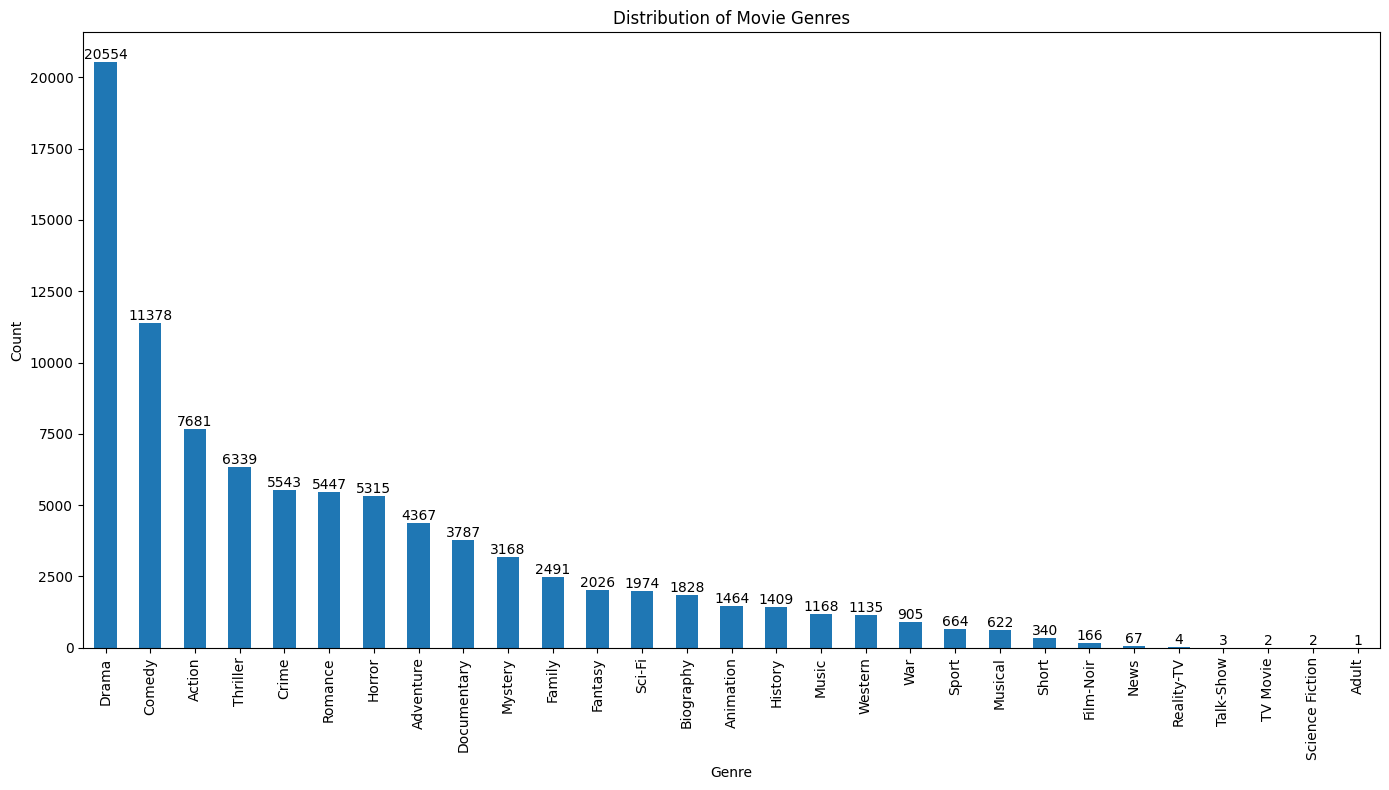

In [110]:
# Step 1: Calculate the total count per genre and sort genres by total count in descending order
genre_movie_total_counts = genre_movie_trend.sum().sort_values(ascending=False)
ax1=genre_movie_total_counts.plot(kind='bar',figsize=(14, 8))

plt.title("Distribution of Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}',  # The value to display
                (p.get_x() + p.get_width() / 2, p.get_height()),  # The position of the label
                ha='center',  # Horizontal alignment
                va='bottom',  # Vertical alignment
                fontsize=10,  # Font size
                color='black') 
plt.show()

Now we can find the Distribution of TV show Genres

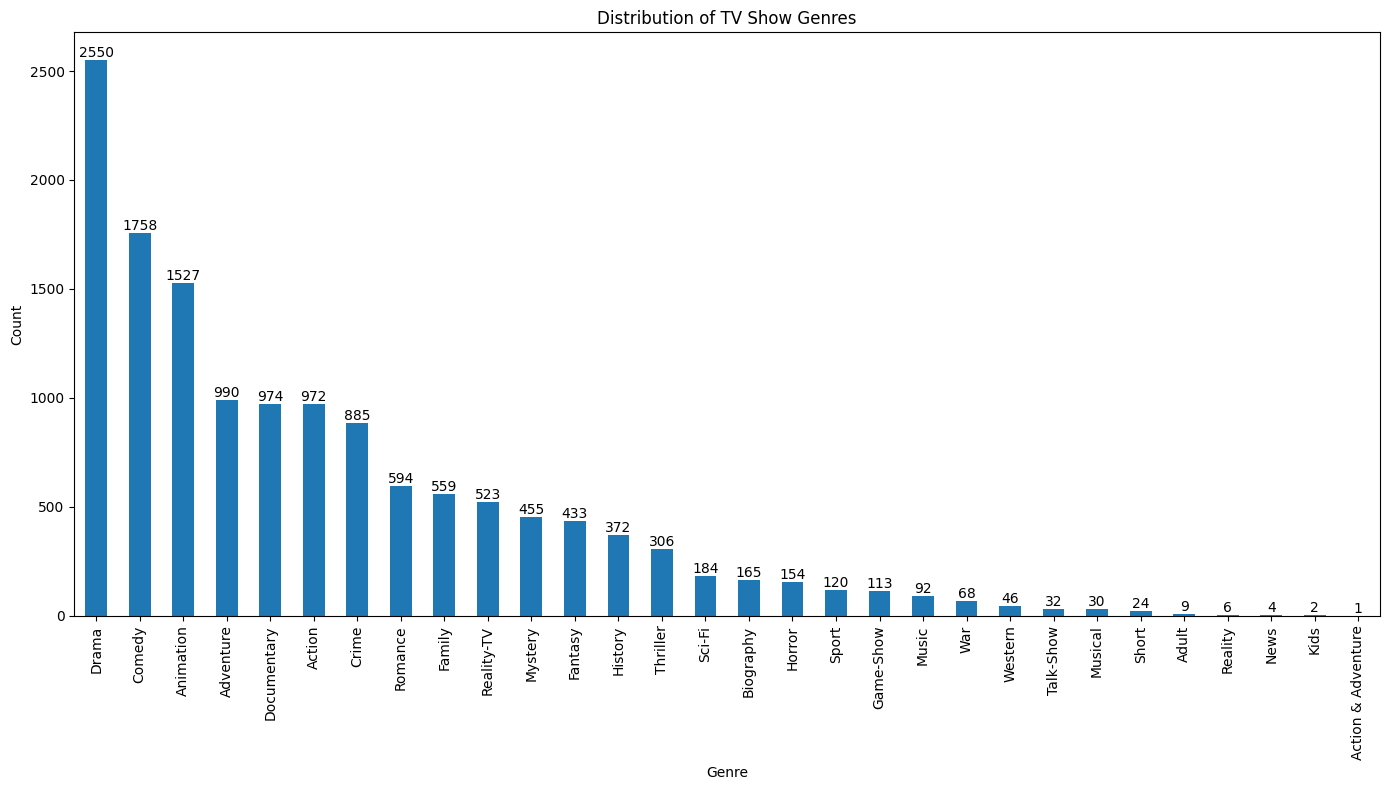

In [111]:
# Step 1: Calculate the total count per genre and sort genres by total count in descending order
genre_tv_total_counts = genre_tv_trend.sum().sort_values(ascending=False)
ax2=genre_tv_total_counts.plot(kind='bar',figsize=(14, 8))
plt.title("Distribution of TV Show Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}',  # The value to display
                (p.get_x() + p.get_width() / 2, p.get_height()),  # The position of the label
                ha='center',  # Horizontal alignment
                va='bottom',  # Vertical alignment
                fontsize=10,  # Font size
                color='black') 
plt.show()

### Countrywise Analysis

In [112]:
df_country_name = pd.read_csv('Country Mapping.csv')
df_country_name.head()

,Name,Code
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


##### Countrywise Movie Genre analysis

In [113]:
# Step 1: Filter the dataframe by movie and Explode the available countries column to have one country per row
df_movieCountry = df1[df1['type']=='movie']
df_movieCountry_exploded = df_movieCountry.explode('availableCountries')
df_movie_exploded_overall = df_movieCountry_exploded.explode('genres')
df_movie_exploded_overall.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Blondie,movie,Comedy,1938,tt0029927,6.9,885,US
0,Blondie,movie,Family,1938,tt0029927,6.9,885,US
0,Blondie,movie,Comedy,1938,tt0029927,6.9,885,ZA
0,Blondie,movie,Family,1938,tt0029927,6.9,885,ZA
1,Ariel,movie,Comedy,1988,tt0094675,7.4,8735,JP


In [114]:
#Map the country code with country name and drop the code
df_movie_exploded_country = df_movie_exploded_overall.merge(df_country_name,how='inner',left_on='availableCountries',right_on='Code')
df_movie_country=df_movie_exploded_country.drop(columns=['availableCountries','Code'],axis=1).reset_index(drop=True)
df_movie_country.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,Name
0,Blondie,movie,Comedy,1938,tt0029927,6.9,885,United States
1,Blondie,movie,Family,1938,tt0029927,6.9,885,United States
2,Blondie,movie,Comedy,1938,tt0029927,6.9,885,South Africa
3,Blondie,movie,Family,1938,tt0029927,6.9,885,South Africa
4,Ariel,movie,Comedy,1988,tt0094675,7.4,8735,Japan


In [115]:
# Step 1: Group by country and genres, then count occurrences
movie_genre_country_final = df_movie_country.groupby(['Name', 'genres']).size().unstack(fill_value=0)
movie_genre_country_final

genres,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Romance,Sci-Fi,Science Fiction,Short,Sport,TV Movie,Talk-Show,Thriller,War,Western
Name,,,,,,,,,,,,,,,,,,,,,
Albania,125,0,86,23,24,143,59,16,155,13,...,48,31,0,2,4,0,0,87,3,8
Algeria,241,0,108,25,28,261,94,16,351,31,...,129,30,0,1,8,0,0,129,4,11
Andorra,417,0,268,68,93,400,211,20,600,42,...,181,104,0,4,15,0,0,231,25,14
Angola,247,0,134,46,58,313,119,132,520,72,...,150,42,0,14,26,0,0,166,5,14
Antigua and Barbuda,744,0,375,212,157,1246,403,496,1749,230,...,561,150,0,66,68,0,1,508,45,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,998,0,589,246,202,1169,601,220,2037,299,...,533,211,0,22,83,0,0,706,58,59
"Venezuela, Bolivarian Republic of",1000,0,592,246,201,1171,604,220,2039,299,...,539,211,0,21,82,0,0,708,58,59
Yemen,240,0,109,25,29,261,94,16,353,31,...,129,30,0,1,8,0,0,129,3,11


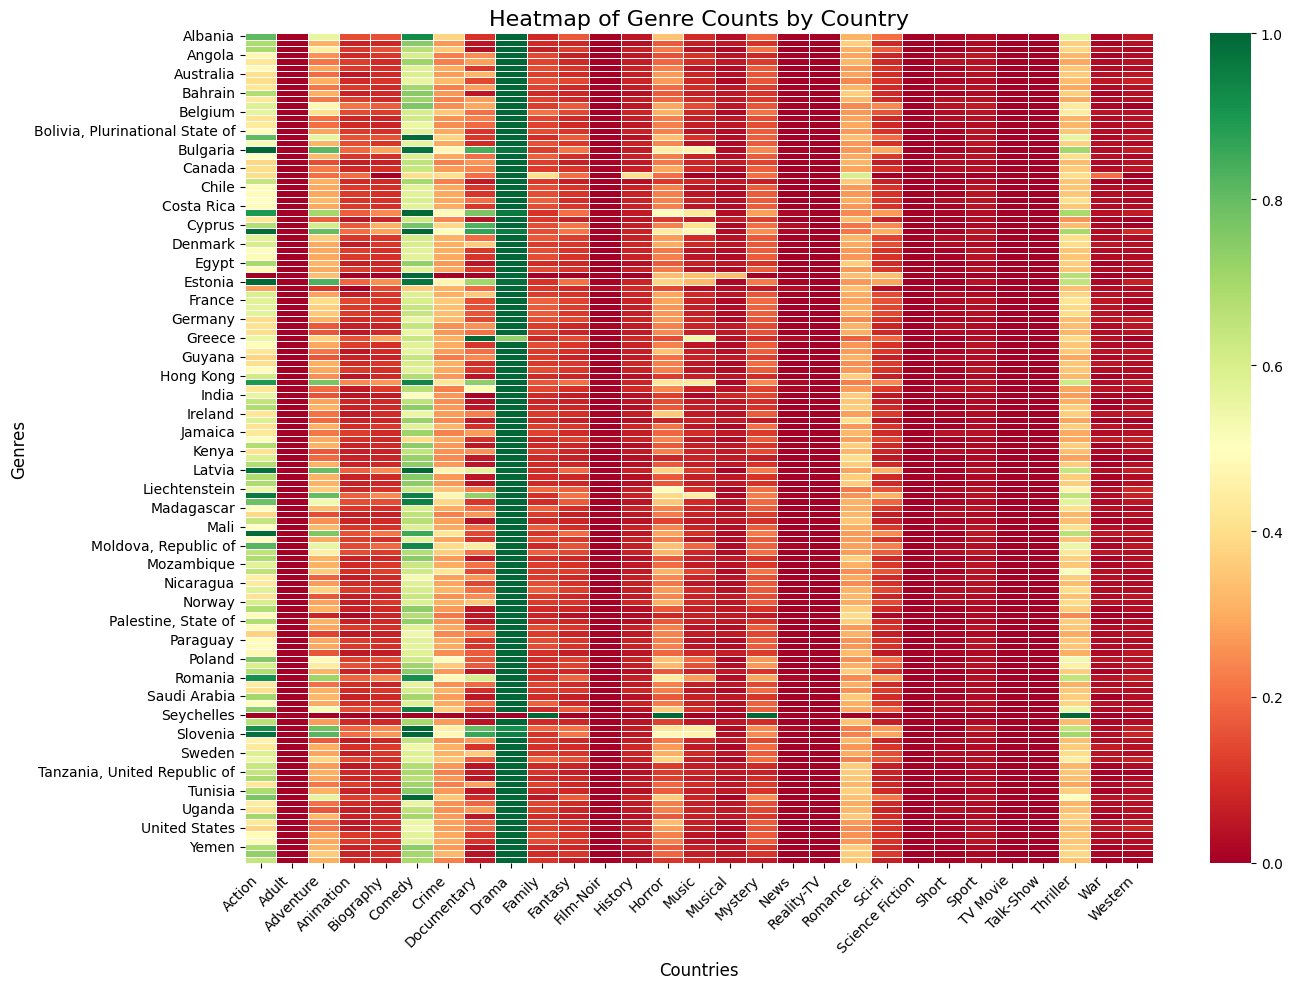

In [116]:
# Normalize the data for each country so that we can find popular genre for each country
normalized_movie_df = movie_genre_country_final.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Create a heatmap
plt.figure(figsize=(14, 10))  # Increase figure size
sns.heatmap(normalized_movie_df, annot=False, cmap='RdYlGn', cbar=True, 
            linecolor='white', linewidths=0.5, vmin=0, vmax=1)

# Rotate axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)                # Rotate y-axis labels

# Adding titles and labels
plt.title('Heatmap of Genre Counts by Country', fontsize=16)
plt.xlabel('Countries', fontsize=12)
plt.ylabel('Genres', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

From the above heat map it is evident that Drama Genre is popular movies in most of the countries. 
And War and Western genre is less popular in all countries

##### Countrywise TV Show Genre analysis

In [117]:
# Filter the dataframe by tv and Explode the available countries column to have one country per row
df_tvCountry = df1[df1['type']=='tv']
df_tvCountry_exploded = df_tvCountry.explode('availableCountries')
df_tv_exploded_overall = df_tvCountry_exploded.explode('genres')
df_tv_exploded_overall.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
42146,The Amazing Mrs Pritchard,tv,Comedy,2006,tt0807980,7.6,546,GB
42146,The Amazing Mrs Pritchard,tv,Drama,2006,tt0807980,7.6,546,GB
42146,The Amazing Mrs Pritchard,tv,Comedy,2006,tt0807980,7.6,546,GG
42146,The Amazing Mrs Pritchard,tv,Drama,2006,tt0807980,7.6,546,GG
42146,The Amazing Mrs Pritchard,tv,Comedy,2006,tt0807980,7.6,546,US


In [118]:
#Map the country code with country name and drop the code
df_tv_exploded_country = df_tv_exploded_overall.merge(df_country_name,how='inner',left_on='availableCountries',right_on='Code')
df_tv_country=df_tv_exploded_country.drop(columns=['availableCountries','Code'],axis=1).reset_index(drop=True)
df_tv_country.head()

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,Name
0,The Amazing Mrs Pritchard,tv,Comedy,2006,tt0807980,7.6,546,United Kingdom
1,The Amazing Mrs Pritchard,tv,Drama,2006,tt0807980,7.6,546,United Kingdom
2,The Amazing Mrs Pritchard,tv,Comedy,2006,tt0807980,7.6,546,Guernsey
3,The Amazing Mrs Pritchard,tv,Drama,2006,tt0807980,7.6,546,Guernsey
4,The Amazing Mrs Pritchard,tv,Comedy,2006,tt0807980,7.6,546,United States


In [119]:
# Group by country and genres, then count occurrences
tv_genre_country_final = df_tv_country.groupby(['Name', 'genres']).size().unstack(fill_value=0)
tv_genre_country_final

genres,Action,Action & Adventure,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Reality,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
Name,,,,,,,,,,,,,,,,,,,,,
Albania,78,0,0,53,43,11,189,62,93,245,...,0,47,60,16,1,47,4,53,0,1
Algeria,77,0,0,56,49,11,197,63,95,252,...,0,49,60,15,1,49,4,52,0,1
Andorra,116,0,0,100,94,12,245,85,96,326,...,0,46,73,19,1,51,5,68,0,1
Angola,63,0,0,55,82,10,157,53,73,217,...,0,28,45,16,2,39,4,33,0,0
Antigua and Barbuda,118,0,0,116,132,21,283,101,156,324,...,4,102,64,22,4,53,5,64,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,140,0,0,137,175,25,280,101,124,382,...,1,65,81,27,5,53,6,69,3,3
"Venezuela, Bolivarian Republic of",139,0,0,137,171,25,278,103,124,385,...,1,65,84,27,5,54,6,70,1,3
Yemen,73,0,0,55,48,11,184,60,94,239,...,0,49,50,15,1,48,4,49,0,1


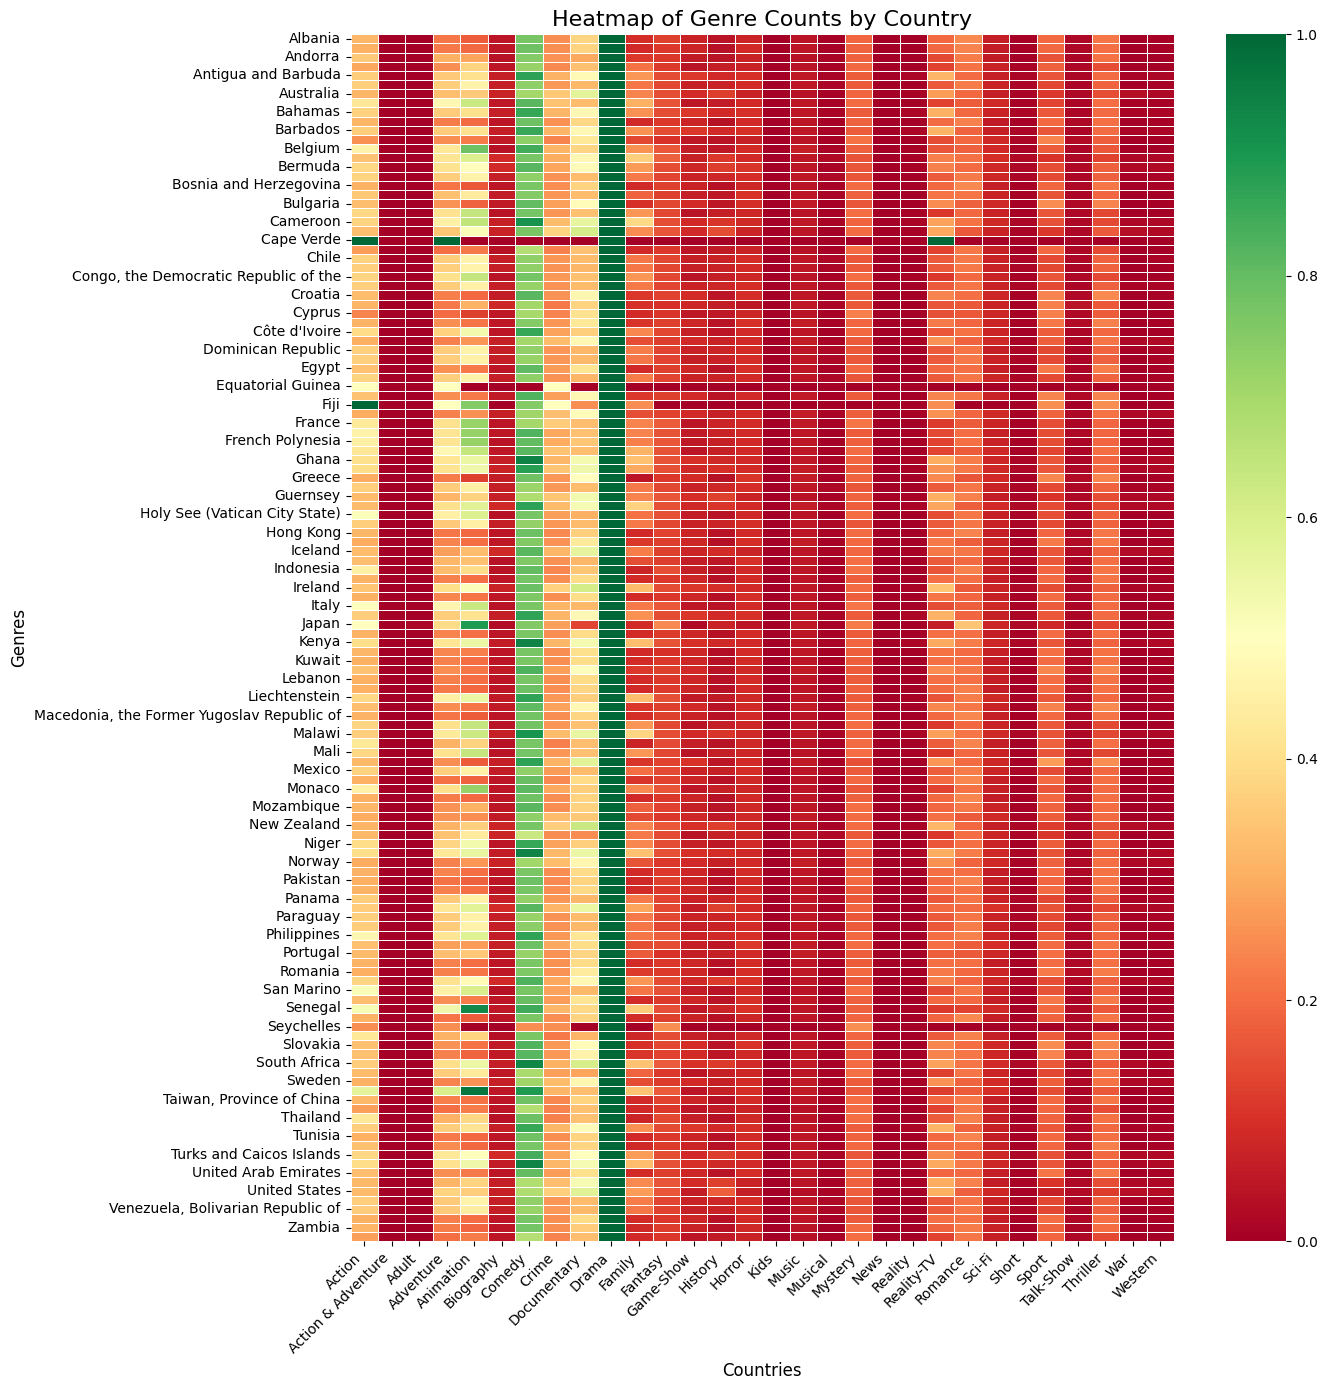

In [120]:
# Normalize the data for each country so that we can find popular genre for each country
normalized_tv_df = tv_genre_country_final.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Create a heatmap
plt.figure(figsize=(14, 14))  # Increase figure size
sns.heatmap(normalized_tv_df, annot=False, cmap='RdYlGn', cbar=True, 
            linecolor='white', linewidths=0.5, vmin=0, vmax=1)

# Rotate axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)                # Rotate y-axis labels

# Adding titles and labels
plt.title('Heatmap of Genre Counts by Country', fontsize=16)
plt.xlabel('Countries', fontsize=12)
plt.ylabel('Genres', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

From the above heat map it is evident that Drama Genre is popular tv show in all country and Action is popular in Fiji. 
And War and Western genre is less popular in all countries

### Clustering the movies

In [121]:
features = final_df.drop(columns=['title','type','imdbId','genres','availableCountries'],axis=1).reset_index(drop=True)
features.head()

,releaseYear,imdbAverageRating,imdbNumVotes,movie,tv,Action,Action & Adventure,Adult,Adventure,Animation,...,TZ,UG,US,UY,VA,VE,YE,ZA,ZM,ZW
0,1938,6.9,885,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,1988,7.4,8735,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1995,6.7,112484,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1993,6.6,19268,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1994,8.8,2313221,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
#Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

K=2, Silhouette Score: 0.7270
K=3, Silhouette Score: 0.3474
K=4, Silhouette Score: 0.1735
K=5, Silhouette Score: 0.1754
K=6, Silhouette Score: 0.1656
K=7, Silhouette Score: 0.1820
K=8, Silhouette Score: 0.2041
K=9, Silhouette Score: 0.0900
K=10, Silhouette Score: 0.0874


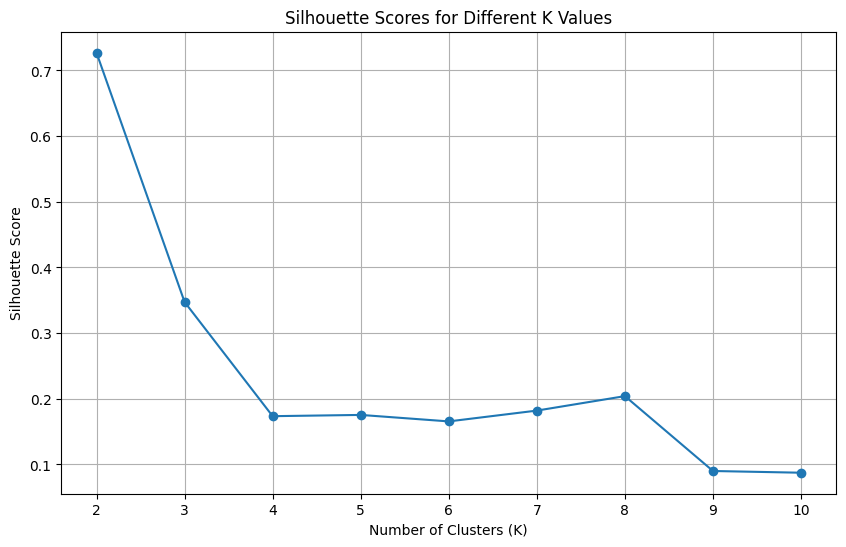

In [123]:
# Define a range of K values to test
k_values = range(2, 11)  # You can adjust this range
silhouette_scores = []

for k in k_values:
    # Step 1: Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Step 2: Calculate the Silhouette Score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'K={k}, Silhouette Score: {silhouette_avg:.4f}')

# Step 3: Plot the silhouette scores for each K value
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid()
plt.show()

From the score it is clear that k=2 has effective clustering compared to the rest of the k value. 

In [124]:
# The best k = 2
best_k = 2

# Fit K-Means with the best K
kmeans = KMeans(n_clusters=best_k, random_state=0)
final_df['main_cluster'] = kmeans.fit_predict(scaled_features)

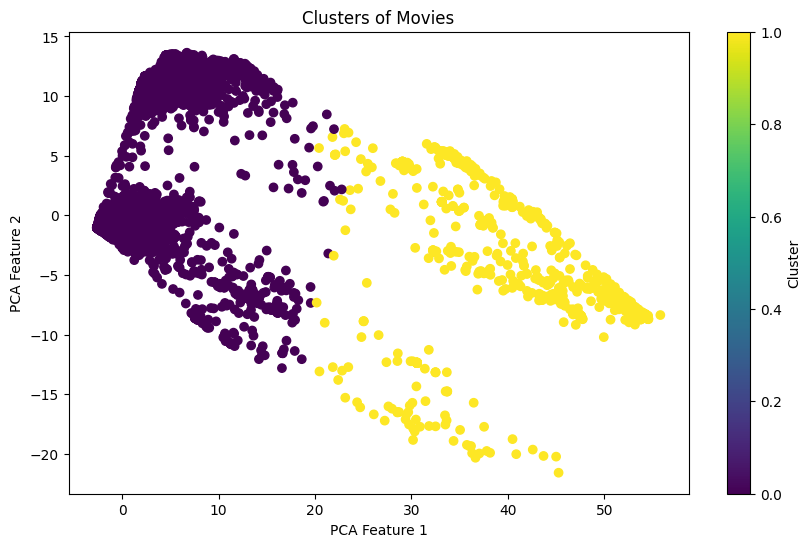

In [125]:
#Dimensionality Reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

#Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=final_df['main_cluster'], cmap='viridis')
plt.title('Clusters of Movies')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()

Since k = 2 has high score, I proceeded with 2. But the cluster that containing only two clusters is not going to give refined recommendation. Hence creating sub-cluster for this main cluster, with sub_k = 4

In [126]:
# The best k = 2
best_k = 2

# Fit K-Means with the best K
kmeans = KMeans(n_clusters=best_k, random_state=0)
final_df['main_cluster'] = kmeans.fit_predict(scaled_features)


# Step 2: Create sub-clusters within each main cluster
# Initialize an empty column to store sub-cluster labels
final_df['sub_cluster'] = -1

# Loop through each main cluster and apply K-Means with smaller k for sub-clustering
for main_cluster_label in range(best_k):
    # Filter the data for the current main cluster
    subset = final_df[final_df['main_cluster'] == main_cluster_label]
    subset_features = scaled_features[final_df['main_cluster'] == main_cluster_label]

    # Apply K-Means on this subset
    sub_k = 4  # you can change this depending on how granular you want the sub-clusters
    kmeans_sub = KMeans(n_clusters=sub_k, random_state=0)
    sub_cluster_labels = kmeans_sub.fit_predict(subset_features)

    # Store the sub-cluster labels in the main DataFrame
    final_df.loc[final_df['main_cluster'] == main_cluster_label, 'sub_cluster'] = sub_cluster_labels



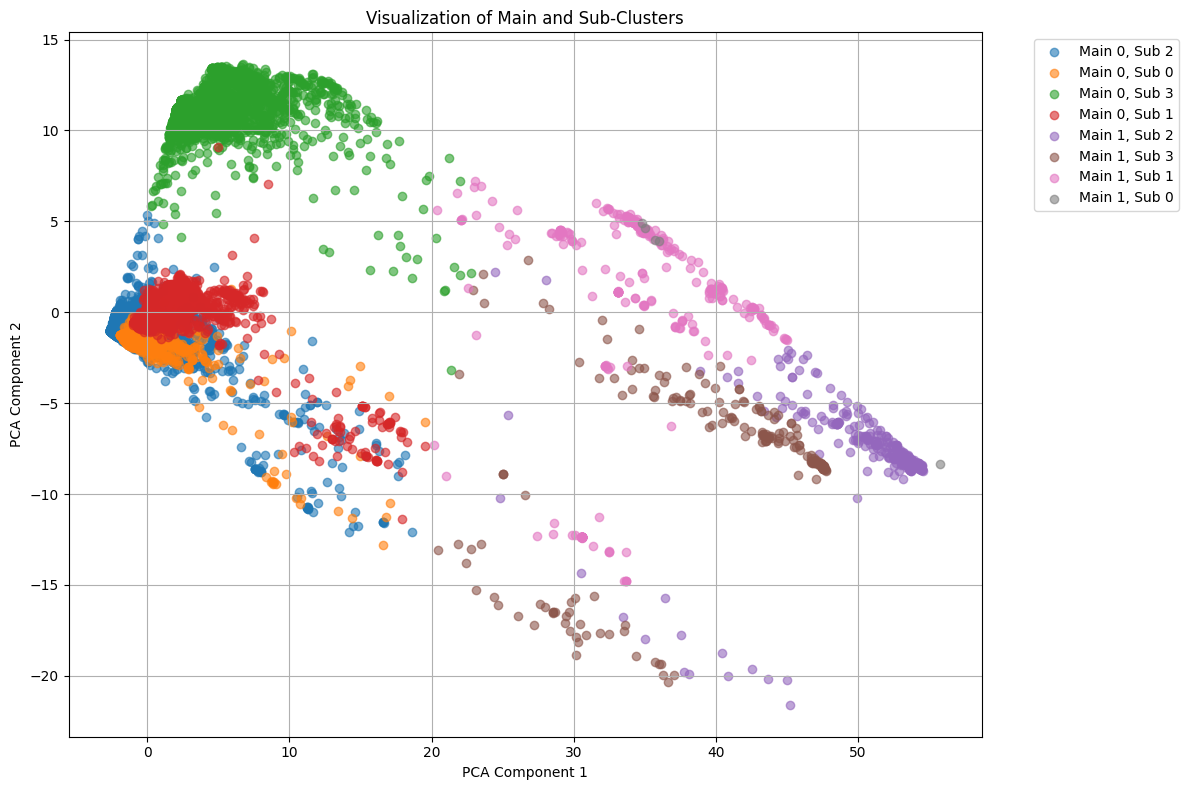

In [127]:
# Step 1: Use PCA to reduce features to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Add the reduced features to the DataFrame for easy plotting
final_df['PCA1'] = reduced_features[:, 0]
final_df['PCA2'] = reduced_features[:, 1]

# Step 2: Plot main clusters with their sub-clusters
plt.figure(figsize=(12, 8))

# Loop over each main cluster
for main_cluster_label in final_df['main_cluster'].unique():
    # Filter data for this main cluster
    main_cluster_data = final_df[final_df['main_cluster'] == main_cluster_label]
    
    # Loop over each sub-cluster within the main cluster
    for sub_cluster_label in main_cluster_data['sub_cluster'].unique():
        sub_cluster_data = main_cluster_data[main_cluster_data['sub_cluster'] == sub_cluster_label]
        
        # Plot each sub-cluster with a distinct color
        plt.scatter(sub_cluster_data['PCA1'], sub_cluster_data['PCA2'],
                    label=f'Main {main_cluster_label}, Sub {sub_cluster_label}', alpha=0.6)
        
# Customize the plot
plt.title("Visualization of Main and Sub-Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [128]:
#Evaluate clustering
score = silhouette_score(scaled_features, final_df['main_cluster'])
print(f'Silhouette Score: {score:.2f}')

Silhouette Score: 0.73


## Recommendation System

Based on the clustered data, now we are going to create a recommendation system using colaborative filtering

In [133]:
genre_encoded_list=list(final_df.columns[10:43])
type_encoded_list=list(final_df.columns[8:10])

In [134]:
features = genre_encoded_list+ type_encoded_list


In [135]:
pivot_table = final_df.pivot_table(index='title', columns=features, values='imdbAverageRating',aggfunc=np.sum, fill_value=0)

In [136]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(pivot_table)
similarity_df = pd.DataFrame(similarity_matrix, index=pivot_table.index, columns=pivot_table.index)
similarity_df.head()

title,#1 Cheerleader Camp,#1 Serial Killer,#AMFAD: All My Friends Are Dead,#Captured,#Female Pleasure,#Followme,#Horror,#IMomSoHard Live,#Iamhere,#Kazoku Boshu Shimasu,...,Éxtasis,Îsutâ naitomea: Shi no îsutâ banî,"Ó Pai, Ó: Look at This",Öteki Taraf,Ørnen,Últimos días en La Habana,Últimos testigos,Über Österreich - Juwele des Landes,Überall wo wir sind,ärtico
title,,,,,,,,,,,,,,,,,,,,,
#1 Cheerleader Camp,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1 Serial Killer,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#AMFAD: All My Friends Are Dead,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Captured,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Female Pleasure,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [137]:
def get_cluster_recommendations(movie_title, final_df, num_recommendations=5):
    # Identify the cluster of the selected movie
    movie_cluster = final_df.loc[final_df['title'] == movie_title, ['main_cluster', 'sub_cluster']].values[0]

    # Get similarity scores from the overall similarity_df
    similar_scores = similarity_df[movie_title].sort_values(ascending=False)

    # Get the titles of movies in the same cluster
    cluster_movies = final_df[(final_df['main_cluster'] == movie_cluster[0]) & (final_df['sub_cluster'] == movie_cluster[1])]

    # Filter similar_scores to include only movies in the same cluster
    recommendations = similar_scores[similar_scores.index.isin(cluster_movies['title'])]

    # Exclude the original movie from recommendations
    recommendations = recommendations[recommendations.index != movie_title]

    # Return the top N recommendations
    return recommendations.head(num_recommendations)





In [138]:
recommendations = get_cluster_recommendations('Gladiator', final_df, num_recommendations=5)
print(recommendations)

title
The Aeronauts                                        1.0
The Lord of the Rings: The Fellowship of the Ring    1.0
The Lord of the Rings: The Return of the King        1.0
The Lord of the Rings: The Two Towers                1.0
The Tomorrow War                                     1.0
Name: Gladiator, dtype: float64
